In [7]:
import jax
import os
import jax.numpy as jnp
import numpy as np
from jax import random
import time
import pickle
import matplotlib.pyplot as plt

In [8]:
if os.path.isdir('datasets/8fmsk'):
    pass
else:
    os.system('mkdir datasets/8fmsk')

### Dataset generation
Sampling rate 20 kHz


8 equally distant MFSK symbols, one noise signal

Freqeuencies offset according to uniform distribution, with 1 \% to their central distribution

Power has gone through ideal AGC so strength of received signal is equal to one.

Noise will be at SNR 15 dB

Imperfect_windows, lets start with half way mismatch

One waveform per permutation


In [9]:
sampling_rate = 20e3
frequnecies = jnp.arange(0, 10e3, 1250)
relative_frequency_offset = 0
frequency_offset = relative_frequency_offset * frequnecies
samples = int(sampling_rate)
SNR = 15

t = jnp.linspace(0, 1, samples)

waveforms = []

key = random.PRNGKey(time.time_ns())



for idx, freq in enumerate(frequnecies):
    for idx2, freq2 in enumerate(frequnecies):
        if freq2 != freq:
            key, subkey = random.split(key)
            phase = random.uniform(key, shape=(1,), minval=0, maxval=2*jnp.pi)
            waveforms.append((jnp.concatenate((jnp.sqrt(2)*jnp.sin(2*jnp.pi*(freq+random.uniform(subkey, 1, minval=-frequency_offset[idx]/2,maxval=frequency_offset[idx]/2))*t[:int(10e3)] + phase),
                                              jnp.sqrt(2)*jnp.sin(2*jnp.pi*(freq2+random.uniform(subkey, 1, minval=-frequency_offset[idx2]/2,maxval=frequency_offset[idx2]/2))*t[int(10e3):] + phase))), idx, idx2))
for idx2, freq2 in enumerate(frequnecies):
    waveforms.append((jnp.concatenate((jnp.zeros(samples//2), jnp.sqrt(2)*jnp.sin(2*jnp.pi*(freq2+random.uniform(subkey, 1, minval=-frequency_offset[idx2]/2,maxval=frequency_offset[idx2]/2))*t[int(10e3):] + phase))), 8, idx2))

# Add noise

waveforms_with_noise = []  

for waveform in waveforms:
    key, subkey = random.split(key)
    waveforms_with_noise.append((waveform[0] + jax.random.normal(subkey, shape=(samples))*jnp.sqrt(1/10**(SNR/10)), waveform[1], waveform[2]))

# Normalize waveforms to power 1
waveforms_with_noise = [(waveform[0]/jnp.sqrt(jnp.mean(waveform[0]**2)), waveform[1], waveform[2]) for waveform in waveforms_with_noise]

# Save waveforms
with open('datasets/8fmsk/waveforms_wrong_sync.pkl', 'wb') as f:
    pickle.dump(waveforms_with_noise, f)

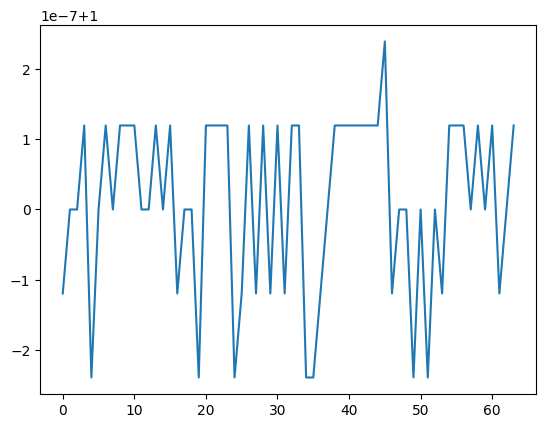

In [10]:

# Calculate mean power of all waveforms
mean_power = [jnp.mean(x[0]**2) for x in waveforms_with_noise]
plt.plot(mean_power)

In [11]:
waveforms_with_noise[2]

(Array([ 0.7974955,  0.8332967,  1.1115386, ..., -1.5914093, -1.3005717,
         0.7349541], dtype=float32),
 0,
 3)

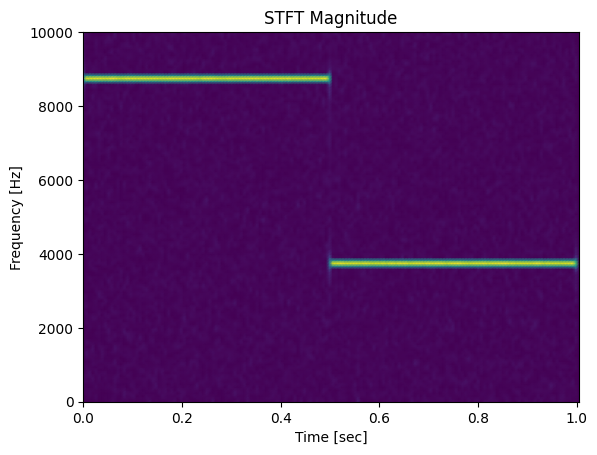

In [29]:
from scipy.signal import stft

# Calculate the stft of a random waveform
idx = random.choice(key,jnp.arange(len(waveforms_with_noise)))

key, subkey = random.split(key)

# Calculate the stft of the waveform
f, t, Zxx = stft(waveforms_with_noise[idx][0], fs=sampling_rate, nperseg=256)
plt.pcolormesh(t, f, jnp.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()